# Семинар 6

## Модель авторегрессии в прогнозировании временных рядов

- Дан временной ряд, например температура (и другие данные из метеорологии) в разное время, цены активов и прочее
- Почти всегда временной ряд – это нелинейная функция.
- Зачастую она периодична
- Простейшая модель – авторегрессионная (AR)
- Идея в прогнозировании $k+1$ значения по последним $M$
- Модель остаётся линейной!

$$\hat{x}_{k+1} = w_1 x_k + \ldots + w_M x_{k - M + 1} $$

- Целевая функция – сумма квадратов невязок (опять!) 

$$ (x_{k+1} - \hat{x}_{k+1})^2 + \ldots + (x_T - \hat{x}_T)^2 \to \min_w $$

- Как представить эту задачу в виде $\|Xw - y \|^2_2 \to \min_w$ ?

- Каким свойством обладает матрица $X$?

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


<AxesSubplot:xlabel='Date'>

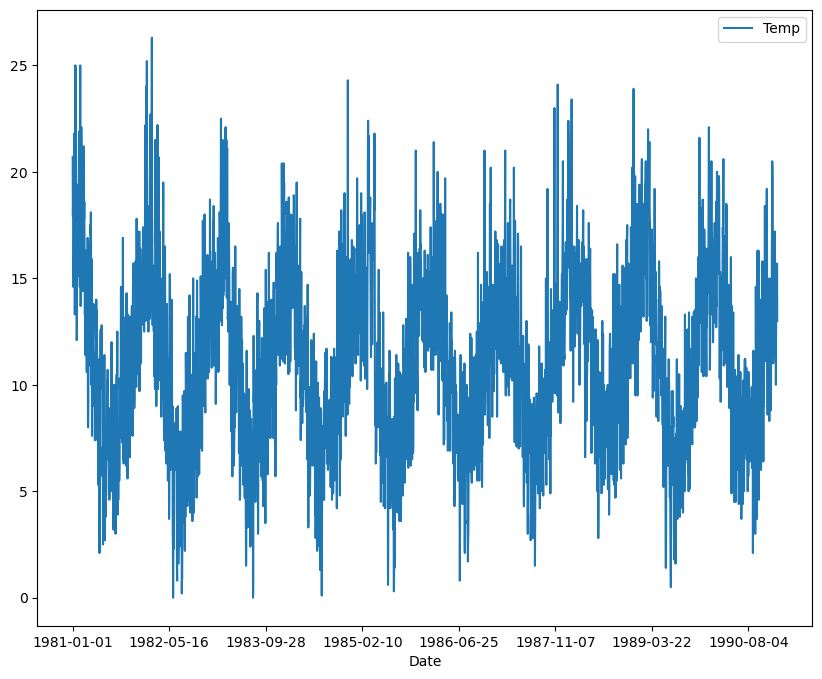

In [2]:
import pandas as pd

series = pd.read_csv('./daily-min-temperatures.csv', header=0, index_col=0)
print(series.head())
series.plot(figsize=(10, 8))

(3650,)


<AxesSubplot:xlabel='Date'>

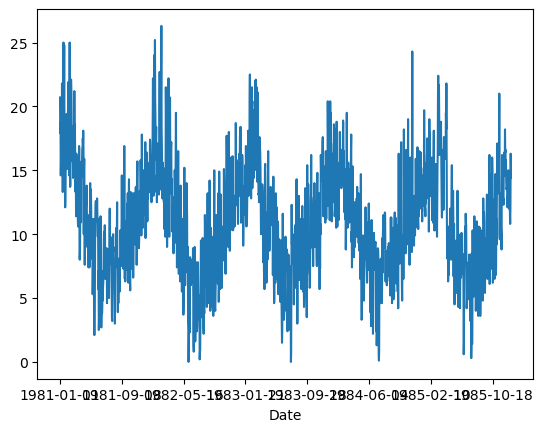

In [3]:
x = series["Temp"]
print(x.shape)
train_x = x[:x.shape[0] // 2]
test_x = x[x.shape[0] // 2:]
train_x.plot()

In [4]:
import numpy as np
mean_forecast = train_x.mean()
print(mean_forecast)
print(np.linalg.norm(train_x - mean_forecast))

11.043506849315076
182.05357880625257


In [5]:
prev_forecast = train_x[:-1].values
# print(prev_forecast)
print(np.linalg.norm((train_x[1:].values - prev_forecast)))

120.3297552561294


In [37]:
import scipy.linalg as splin
M = 600
X = splin.toeplitz(train_x[M-1:-1], train_x[:M][::-1])
y = train_x[M:]
print(X.shape, y.shape)
w = np.linalg.lstsq(X, y, rcond=None)[0]
print(np.linalg.norm(X @ w - y))
print(w)

(1225, 600) (1225,)
64.14389995753919
[ 5.70619361e-01 -1.12978395e-01  7.59236624e-02 -1.50851133e-03
  1.86612002e-02  3.66674612e-02  2.11505754e-02  6.03651269e-02
  2.52398865e-02 -3.21167041e-02 -6.85663874e-03  8.31142183e-02
 -4.52189164e-02  2.99261105e-02 -3.42137684e-03 -1.82598768e-02
  1.35664803e-02 -2.76379248e-02  8.44655167e-03 -4.37806304e-02
  8.82701615e-02  1.24337491e-02  1.83802540e-02 -1.16508829e-02
  4.66795024e-02  2.85644818e-03  9.81457429e-05 -2.08915275e-03
 -4.80927808e-03 -2.39226242e-02  3.77632246e-02 -1.85178031e-02
 -5.82492666e-02  7.06675111e-02 -2.16322632e-02 -1.69968811e-03
  1.17037756e-02 -1.40870351e-02  2.22880599e-02  3.00507021e-02
 -5.78620181e-02 -7.66705129e-03 -5.51989853e-02  1.85060933e-02
 -8.35528228e-03 -2.77734565e-02  5.04082871e-02 -7.64373792e-03
 -7.45284668e-02  2.11554071e-02 -1.71031357e-02  1.58768736e-02
 -8.58569079e-03  7.58308124e-02 -3.24146770e-02 -2.01573048e-02
  2.34596365e-02 -9.26295140e-03  6.98379018e-03 -1.

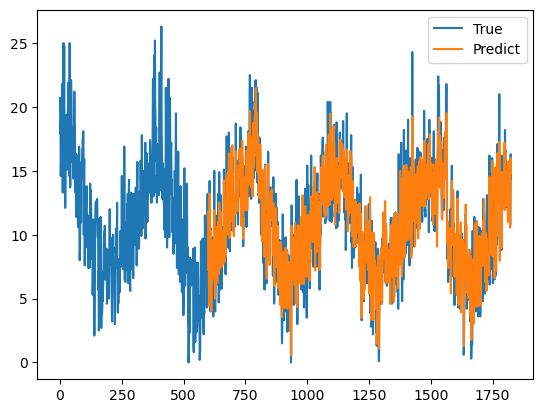

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_x.values, label="True")
plt.plot(np.arange(M, train_x.values.shape[0]), X @ w, label="Predict")
plt.legend()

In [41]:
test_X = splin.toeplitz(test_x[M-1:-1], test_x[:M][::-1])
test_pred = test_X @ w
print(np.linalg.norm(test_pred - test_x[M:]))

106.95136702196463


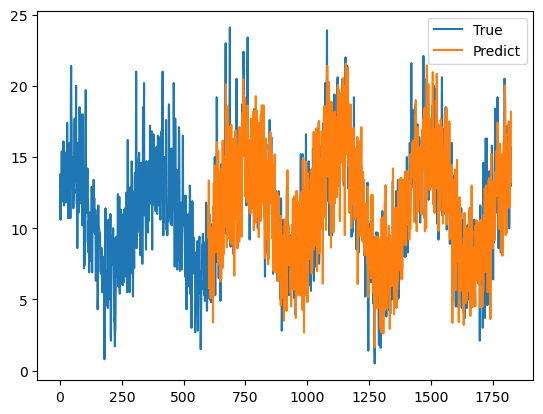

In [40]:
plt.plot(test_x.values, label="True")
plt.plot(np.arange(M, train_x.values.shape[0]), test_pred, label="Predict")
plt.legend()

In [31]:
Ms = np.arange(1, 501, 10)
train_errors = np.zeros((Ms.shape[0],))
test_errors = np.zeros((Ms.shape[0],))
for i, M in enumerate(Ms):
    X = splin.toeplitz(train_x[M-1:-1], train_x[:M][::-1])
    y = train_x[M:]
    w = np.linalg.lstsq(X, y, rcond=None)[0]
    train_errors[i] = np.linalg.norm(X @ w - y)
    test_X = splin.toeplitz(test_x[M-1:-1], test_x[:M][::-1])
    test_pred = test_X @ w
    test_errors[i] = np.linalg.norm(test_pred - test_x[M:])

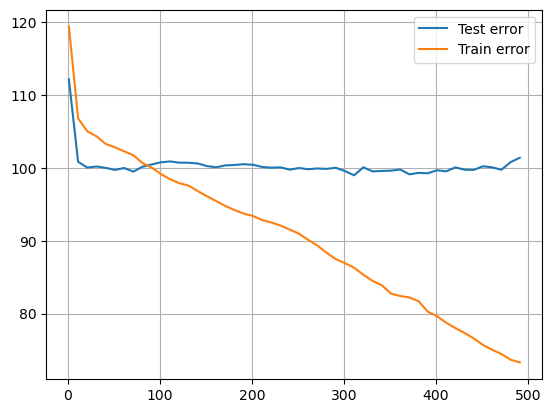

In [32]:
plt.plot(Ms, test_errors, label="Test error")
plt.plot(Ms, train_errors, label="Train error")
plt.legend()
plt.grid(True)

### Томография сетей 

- Дана сеть из $n$ рёбер
- Каждое ребро вносит некоторую задержку $d_i$
- Чтобы выяснить характеристики сети, то есть найти вектор $d$, по сети запускают большое число сигналов по различным маршрутам и измеряют время прохождения сигнала $t_i$, $i=1,\ldots, N$ по известному маршруту
- Маршрут описывается бинарной матрицей $P$ размера $N \times n$ такой что

$$p_{ij} = \begin{cases} 1, & j \in \mathcal{P}_i\\ 0, & \text{иначе}, \end{cases} $$

где $\mathcal{P}_i$ – путь $i$.

- Необходимо по матрице $P$ и вектору $t$ определить вектор $d$, описывающий сеть

**Приложения**

- Дорожные сети
- Компьютерные сети

## Решение линейных систем, обратная матрица

### Напоминание основных фактов

- Линейная система имеет вид

$$ Ax = b,$$

с квадратной $n \times n$ матрицей $A$

- Для любой матрицы существуют PLU разложение

$$ A = PLU, $$

$P$ – матрица перестановки, $L$ – нижнетреугольная матрица, $U$ – верхнетреугольная матрица.

- Сложность $\mathcal{O}(n^3)$
- Если $A \succ 0$, то матрица раскладывается на факторы $A = LL^*$ – разложение Холецкого 
- Обратная матрица $A^{-1}$ существует для невырожденных матриц и $AA^{-1} = A^{-1}A = I$
- Тогда $x = A^{-1}b$ или $x = U^{-1}L^{-1}P^*b$

### Push-through identity

- Дано $A \in \mathbb{R}^{m \times n}$, $B \in \mathbb{R}^{n \times m}$ и $I + AB$ обратима
- Покажем, что и $I + BA$ обратима
- Также покажем, что $(I + BA)^{-1}B = B(I + AB)^{-1}$ 

### Формула Шермана-Морисона-Вудбери

- $(I+P)^{-1} = I - (I+P)^{-1}P = I - P(I+P)^{-1}$
- Ранее доказанное утверждение $(I + BA)^{-1}B = B(I + AB)^{-1}$ 
- Применим к $(I + UV)^{-1} = I - UV(I + UV)^{-1} = I - U(I + VU)^{-1}V$
- Формула Шермана-Морисона-Вудбери

$$(A + UCV)^{-1} = A^{-1} - A^{-1}U (C^{-1} + VA^{-1}U)^{-1}VA^{-1} $$

### Определение координат по дополнительным измерениям

- Дано положение 4 объектов в пространстве $a_1$, $a_2$, $a_3$ и $a_4$
- Известны расстояния между ними и искомым объектом $x$: $r_1$, $r_2$, $r_3$ и $r_4$
- Как определить положение $x$?

### Выигрыш от LU факторизации при решении систем с многими правыми частями

- Дан набор систем $Ax = b_1$, $Ax = b_2, \ldots$
- Посмотрим на выигрыш в скорости при использовании однократной факторизации матрицы $A$

In [25]:
n = 1000
time_factor = []
time_full = []
A = np.random.randn(n, n)
t = %timeit -o -q -r 5 splin.lu_factor(A)
factor_time = t.best
lu = splin.lu_factor(A)
num_rhs = 10
for i in range(num_rhs):
    x_true = np.random.randn(n)
    b = A @ x_true
    t = %timeit -o -q np.linalg.solve(A, b)
    time_full.append(t.best)
    t = %timeit -o -q splin.lu_solve(lu, b)
    time_factor.append(t.best)

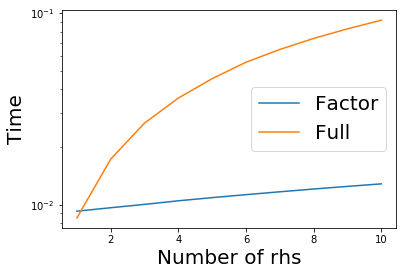

In [34]:
plt.plot(np.arange(1, num_rhs+1), factor_time + np.cumsum(np.array(time_factor)), label="Factor")
plt.plot(np.arange(1, num_rhs+1), np.cumsum(np.array(time_full)), label="Full")
plt.legend(fontsize=20)
plt.xlabel("Number of rhs", fontsize=20)
plt.ylabel("Time", fontsize=20)
plt.yscale("log")

### Резюме

- Приложения задачи наименьших квадратов
- Приложения и свойства обратных матриц и систем линейных уравнений